In [1]:
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):

        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [3]:
import numpy as np
from collections import Counter

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        # Initialize the DecisionTree with specified parameters



        self.min_samples_split = min_samples_split# min_samples_split: minimum number of samples required to split a node
        self.max_depth = max_depth# max_depth: maximum depth of the tree
        self.n_features = n_features  # n_features: number of features to consider when looking for the best split
        self.root = None  # Root of the decision tree

    def fit(self, X, y):
        # Fit the decision tree to the training data
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        # Recursively grow the decision tree by splitting nodes
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Check stopping criteria: maximum depth, pure node, or not enough samples
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            class_probs = np.bincount(y.astype(int), minlength=n_labels) / len(y)
            print(f"Leaf node: value={leaf_value}, class_probs={class_probs}")
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # Find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)
        information_gain = self._information_gain(y, X[:, best_feature], best_thresh)
        print(f"Node: feature={best_feature}, threshold={best_thresh}, information_gain={information_gain}")

        # Create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        # Find the best split for a subset of features
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # Calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        # Calculate information gain for a split
        parent_entropy = self._entropy(y)

        # Create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # Calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        # Split the data based on a threshold
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        # Calculate entropy of a set of labels
        y = np.round(y).astype(int)
        hist = np.bincount(y)
        ps = hist / len(y)
        return float(-np.sum([p * np.log(p) for p in ps if p > 0]))

    def _most_common_label(self, y):
        # Find the most common label in a set of labels
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        # Predict labels for input data
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        # Traverse the decision tree to find the predicted label for a given input
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [4]:
import numpy as np
from collections import Counter

class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        # Initialize the RandomForest with specified parameters
        # n_trees: number of decision trees in the random forest
        # max_depth: maximum depth of each decision tree
        # min_samples_split: minimum number of samples required to split a node in each tree
        # n_feature: number of features to consider when looking for the best split in each tree
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_feature
        self.trees = []  # List to store the individual decision trees

    def fit(self, X, y):
        # Fit the random forest to the training data
        self.trees = []
        for _ in range(self.n_trees):
            # Create a decision tree and fit it to a bootstrap sample of the data
            tree = DecisionTree(max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split,
                                n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)  # Add the trained tree to the list

    def _bootstrap_samples(self, X, y):
        # Generate a bootstrap sample from the training data
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        # Find the most common label in a set of labels
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        # Make predictions using the random forest
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        # For each set of predictions from the trees, choose the most common label
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions


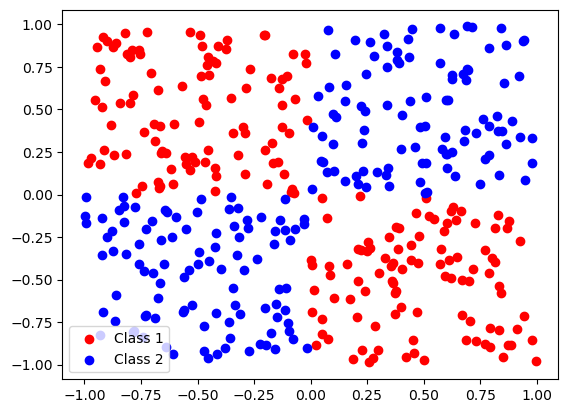

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate points for Class 1
x1 = np.concatenate([np.random.uniform(0, 1, 100), np.random.uniform(-1, 0, 100)])
y1 = np.concatenate([np.random.uniform(-1, 0, 100), np.random.uniform(0, 1, 100)])
label1 = np.zeros_like(x1)  # create an array of zeros of the same shape as x1 and y1

# Generate points for Class 2
x2 = np.concatenate([np.random.uniform(0, 1, 100), np.random.uniform(-1, 0, 100)])
y2 = np.concatenate([np.random.uniform(0, 1, 100), np.random.uniform(-1, 0, 100)])
label2 = np.ones_like(x2)  # create an array of ones of the same shape as x2 and y2


plt.scatter(x1, y1, c='red', label='Class 1')
plt.scatter(x2, y2, c='blue', label='Class 2')


plt.legend()
plt.show()

In [6]:
# Merge data and labels
X = np.concatenate((np.column_stack((x1, y1)), np.column_stack((x2, y2))))
y = np.concatenate((label1, label2))

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [7]:
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

Node: feature=1, threshold=-0.9639578446298993, information_gain=0.01010952976242252
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, threshold=0.9520065828282417, information_gain=0.009835939132440186
Node: feature=1, threshold=0.5558265441635147, information_gain=0.007784824200738227
Node: feature=0, threshold=0.15183544552596406, information_gain=0.042844158883243666
Node: feature=1, threshold=-0.014218198168634011, information_gain=0.2572579371089385
Node: feature=0, threshold=-0.014944481804423426, information_gain=0.2993044143335636
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=0, threshold=-0.015068826751075348, information_gain=0.5297061990576545
Leaf node: value=0.0, class_probs=[1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Node: feature=1, threshold=-0.02049297316769727, information_gain=0.6581099875431143
Leaf node: value=0.0, class_probs=[1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Node: feature=0, threshold=-0.0198

In [8]:
#accuracy for decision tree
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

0.975

In [9]:
#accuracy for random forest
clf = RandomForest(n_trees=10)
clf.fit(X_train, y_train)
rpredictions = clf.predict(X_test)

Node: feature=0, threshold=-0.7838569038295095, information_gain=0.017752364065838244
Node: feature=1, threshold=-0.014218198168634011, information_gain=0.5235863374812598
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, threshold=-0.45877462398330715, information_gain=0.01943570028935826
Node: feature=0, threshold=-0.014944481804423426, information_gain=0.6740507779895553
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=0, threshold=-0.1061399277029933, information_gain=0.0549327922585775
Node: feature=1, threshold=-0.02699834786436106, information_gain=0.6853142072764582
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, threshold=-0.02049297316769727, information_gain=0.28292890039767515
Node: feature=0, threshold=-0.02916510589917476, information_gain=0.5297061990576545
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_pro

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,rpredictions)

0.9916666666666667

In [11]:
#boundary visualisation
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_mesh = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(X_mesh.reshape(-1, 2))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(-0.5, 2, 1))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='black')

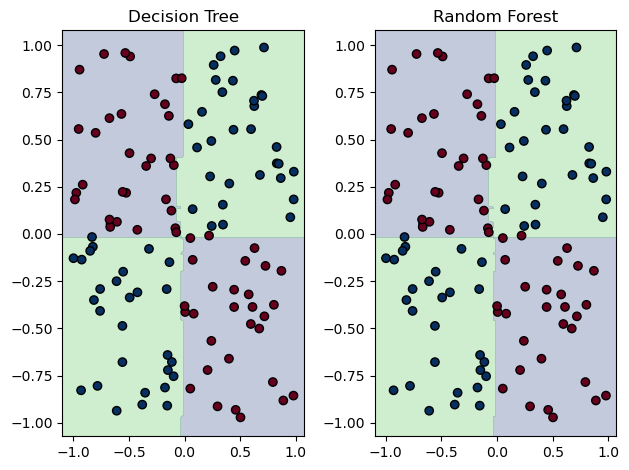

In [12]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, X_test, y_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, X_test, y_test)
plt.tight_layout()
plt.show()

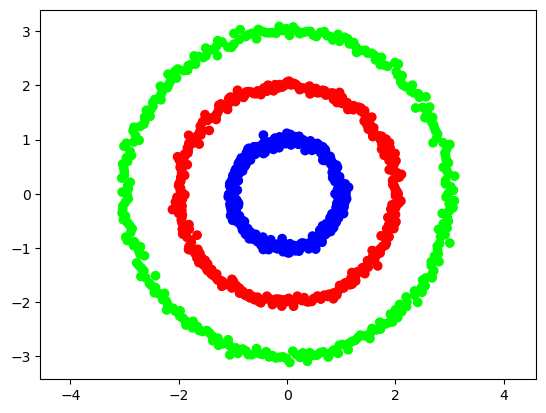

In [13]:
# Set the number of samples and noise level
n = 300
noise = 0.06

# Generate the data
theta = np . linspace (0 , 2* np . pi , n )
r1 = np . random . normal (0 , noise , n ) + 1
r2 = np . random . normal (0 , noise , n ) + 2
r3 = np . random . normal (0 , noise , n ) + 3
x1 = r1 * np . cos ( theta )
y1 = r1 * np . sin ( theta )
x2 = r2 * np . cos ( theta )
y2 = r2 * np . sin ( theta )
x3 = r3 * np . cos ( theta )
y3 = r3 * np . sin ( theta )
# Concatenate the data and labels
X = np . concatenate ([ np . vstack ([ x1 , y1 ]) , np . vstack ([ x2 , y2 ]) , np . vstack ([ x3 , y3]) ] , axis =1)
y = np.concatenate([np.zeros(n),np.ones(n),np.full(n,2)])
# Plot the data
plt.scatter(X[0,:],X[1,:],c=y,cmap = plt.cm.brg )
plt.axis('equal')
plt.show()

In [14]:
X

array([[ 8.85540116e-01,  1.00511930e+00,  1.08897897e+00, ...,
         3.08756378e+00,  2.93439808e+00,  2.97600419e+00],
       [ 0.00000000e+00,  2.11246843e-02,  4.57945694e-02, ...,
        -1.29840573e-01, -6.16725127e-02, -7.28910801e-16]])

In [15]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [16]:
a = np.concatenate([np.vstack([x1, y1]), np.vstack([x2, y2]), np.vstack([x3, y3])], axis=1)
b = np.concatenate([np.zeros(n), np.ones(n), np.full(n, 2)])
a_train, a_test, b_train, b_test = train_test_split(a.T, b, test_size=0.3)

In [17]:
clf = DecisionTree(max_depth=10)
clf.fit(a_train, b_train)
predictions = clf.predict(a_test)

Node: feature=1, threshold=-1.093555364226957, information_gain=0.11466778244952036
Node: feature=1, threshold=-2.0800409008004697, information_gain=0.32584404576371134
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=0, threshold=1.7159854275681863, information_gain=0.24806520259157644
Node: feature=0, threshold=-2.2033147288409065, information_gain=0.39419340249943036
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=1, threshold=1.1164007441265869, information_gain=0.21475606055764673
Node: feature=0, threshold=1.1340171638392422, information_gain=0.22835559528031713
Node: feature=0, threshold=-1.591352742018584, information_gain=0.5571722468166088
Node: feature=0, threshold=-2.705946023230579, information_gain=0.685782896004546
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=0.0, class_probs=[1.]
Node: feature=0, threshold

In [18]:
#accuracy for decision tree
accuracy_score(b_test,predictions)

0.9925925925925926

In [19]:
#accuracy or random forest
clf = RandomForest(n_trees=10)
clf.fit(a_train, b_train)
predictions = clf.predict(a_test)

Node: feature=0, threshold=1.1340171638392422, information_gain=0.1338501605565292
Node: feature=0, threshold=-1.0984995864373333, information_gain=0.2383170912502519
Node: feature=0, threshold=-2.038488884914627, information_gain=0.26016990609294305
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=1, threshold=1.6567780654955624, information_gain=0.25653057025585124
Node: feature=1, threshold=-2.1596766068998496, information_gain=0.46847292908913063
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Node: feature=1, threshold=-1.5790392070778023, information_gain=0.23330972081751522
Node: feature=1, threshold=-2.7986812874030558, information_gain=0.650390640876698
Leaf node: value=2.0, class_probs=[0. 0. 1.]
Leaf node: value=1.0, class_probs=[0. 1.]
Node: feature=1, threshold=1.1164007441265869, information_gain=0.5113337706769422
Leaf node: value=0.0, class_probs=[1.]
Node: feature=1, threshold

In [20]:
accuracy_score(b_test, predictions)

0.9814814814814815

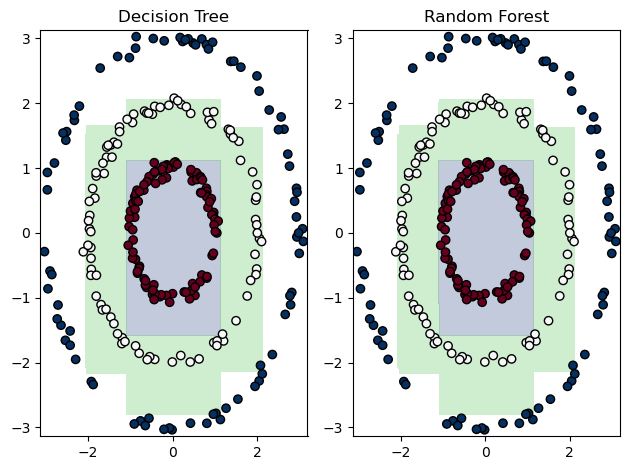

In [21]:
#Boundary Visualization
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, a_test, b_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, a_test, b_test)
plt.tight_layout()
plt.show()

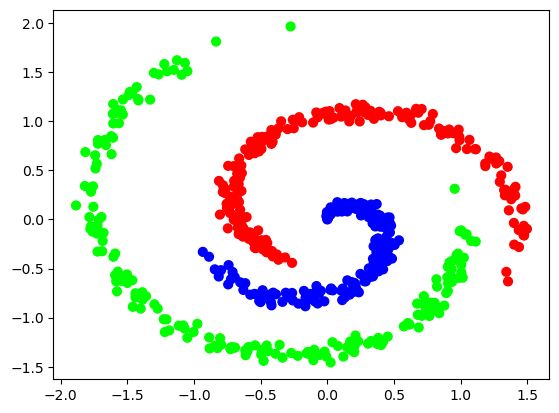

In [22]:
#Unbalanced Spiral dataset
#Generate a 2D dataset consisting of 3 classes arranged in a spiral pattern.
#The dataset has a total of 600 points, with 200 points per class. 
#The variable X is a matrix of size 600x2, where each row represents a data point in 2D space.
#The variable y is a vector of size 600, where each element represents 
#the class label (0, 1, or 2) of the corresponding data point in X.
N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix ( each row = single example )
y = np.zeros(N*K,dtype='uint8') # class labels
for j in range (K):
    ix = range (N*j,N*(j+1))
    r = np.linspace (0.0,1,N) # radius
    r = r+j*0.5
    t = np.linspace(j*4,(j+1)*4,N)+np.random.randn(N)*0.2 # theta
    X[ix]=np.c_[r*np.sin(t),r*np.cos(t)]
    y[ix]=j
spiral4 = np.column_stack((X,y))
plt.scatter(X[:,0],X[:,1],c=y,s=40,cmap='brg')
plt.show()

In [23]:
# Accuracy for Decision Tree
C_train, C_test, D_train, D_test = train_test_split(X,y, test_size=0.3)
clf = DecisionTree(max_depth=5)
clf.fit(C_train, D_train)
predictions = clf.predict(C_test)

Node: feature=1, threshold=0.17568727770164752, information_gain=0.23676446526101613
Node: feature=1, threshold=-0.8777306869671422, information_gain=0.23479059338272934
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-1.3589833862238636, information_gain=0.20442895608291178
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.48509799956095045, information_gain=0.32441937270392807
Node: feature=0, threshold=-0.264061101401777, information_gain=0.2702238558504855
Leaf node: value=1, class_probs=[0.40983607 0.59016393]
Leaf node: value=0, class_probs=[1.]
Node: feature=0, threshold=1.1131150505566603, information_gain=0.5341593666871499
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=0, threshold=-0.8337929374851801, information_gain=0.5364117457223598
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=1, class_probs=[0. 1.]


In [24]:
accuracy_score(D_test,predictions)

0.9388888888888889

In [25]:
#accuracy for random forest
clf = RandomForest(n_trees=10)
clf.fit(C_train, D_train)
predictions = clf.predict(C_test)

Node: feature=1, threshold=-0.4611846846708674, information_gain=0.22594196846485703
Node: feature=1, threshold=-0.8496571763103434, information_gain=0.27135123795471033
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.39161498868626776, information_gain=0.23037437608096095
Node: feature=0, threshold=-1.3589833862238636, information_gain=0.5220770639132397
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=0, class_probs=[1.]
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-1.0489966841499094, information_gain=0.3032685799467677
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=1, threshold=0.17568727770164752, information_gain=0.28277644453897816
Node: feature=0, threshold=-0.264061101401777, information_gain=0.3806611849592114
Node: feature=0, threshold=-0.88685795816845, information_gain=0.11690684913753106
Leaf node: value=0, class_probs=[1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=0, threshold=0.47827611524

In [26]:
accuracy_score(D_test,predictions)

0.9611111111111111

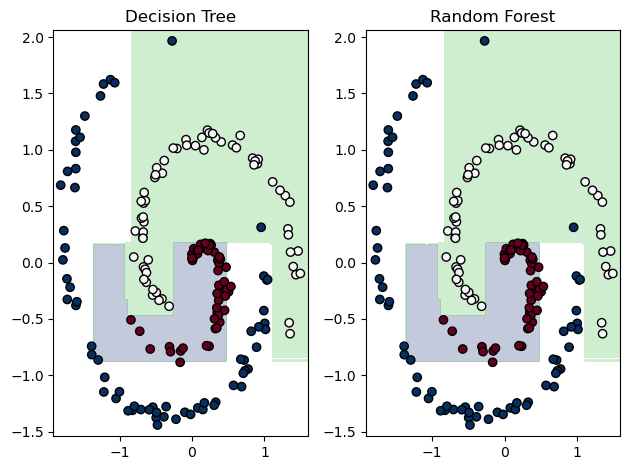

In [27]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, C_test, D_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, C_test, D_test)
plt.tight_layout()
plt.show()

In [ ]:
#Balanced Spiral The dataset has the same number of points and classes as before,
#but the radius increment for each class is now smaller

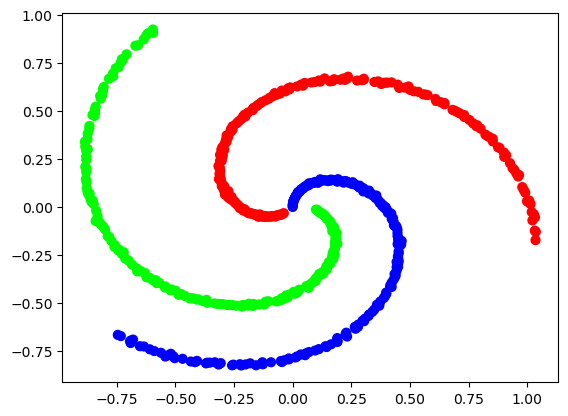

In [28]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np . zeros (( N *K , D ) ) # data matrix ( each row = single example )
y = np . zeros ( N *K , dtype ='uint8') # class labels
for j in range ( K ) :
    ix = range (N *j , N *( j +1) )
    r = np . linspace (0.0 ,1 , N ) # radius
    r = r + j *0.05
    # print (r)
    t = np . linspace ( j *4 ,( j +1) *4 , N ) + np . random . randn ( N ) *0.02 # theta
    # print (t)
    X [ ix ] = np . c_ [ r * np . sin ( t ) , r * np . cos ( t ) ]
    y [ ix ] = j
spiral5 = np . column_stack (( X , y ) )
np . savetxt ("spiral3u.csv", spiral5 , delimiter =",", header ="x,y,label", comments
="", fmt ='%.5f')
plt . scatter ( X [: , 0] , X [: , 1] , c =y , s =40 , cmap ='brg')
plt . show ()

In [29]:
#Accuracy for Decision Tree
A_train, A_test, b_train, b_test = train_test_split(X,y, test_size=0.3)
clf = DecisionTree(max_depth=5)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=1, threshold=0.14479028164071603, information_gain=0.2283466264618872
Node: feature=1, threshold=-0.05894965359213696, information_gain=0.17551439590130347
Node: feature=1, threshold=-0.5464226973882513, information_gain=0.32392076521961816
Leaf node: value=0, class_probs=[1.]
Node: feature=0, threshold=0.19061844814080897, information_gain=0.544508901735393
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=0.4649527290165965, information_gain=0.24493002679463532
Leaf node: value=0, class_probs=[1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=0, threshold=-0.04238331677496587, information_gain=0.3723837257029535
Node: feature=0, threshold=-0.8321889666028847, information_gain=0.42270908780599087
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=0, threshold=0.4206506506638325, information_gain=0.35762715985322163
Node: feature=1, threshold=-0.014008281926909555, information_gain=0.265348289389292

In [30]:
accuracy_score(b_test,predictions)

0.9666666666666667

In [31]:
#Accuracy for Random Forest
clf = RandomForest(n_trees=10)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=1, threshold=0.14479028164071603, information_gain=0.26056664213483516
Node: feature=0, threshold=0.19061844814080897, information_gain=0.17297418929511044
Node: feature=1, threshold=-0.6660298681522169, information_gain=0.22180948456010696
Leaf node: value=0, class_probs=[1.]
Node: feature=1, threshold=-0.0796430902969741, information_gain=0.4481465449833739
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=0, threshold=-0.04238331677496587, information_gain=0.5542958765876745
Node: feature=0, threshold=-0.8321889666028847, information_gain=0.5432727813369008
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=1, threshold=-0.014008281926909555, information_gain=0.40411826492136166
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=0, class_probs=[1.]
Node: feature=0, threshold=0.4649527290165965, information_gain=0.48365398151328826
Leaf node: value=0, class_probs=[1.]
Leaf node: value=1, class_probs=[0. 1.]
N

In [32]:
accuracy_score(b_test,predictions)

0.9833333333333333

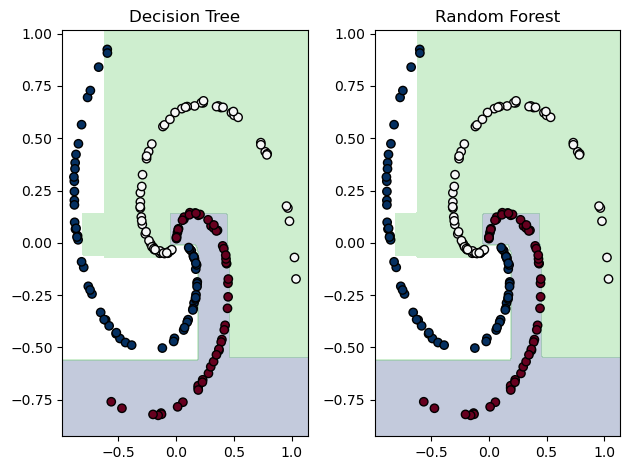

In [33]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, A_test, b_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, A_test, b_test)
plt.tight_layout()
plt.show()

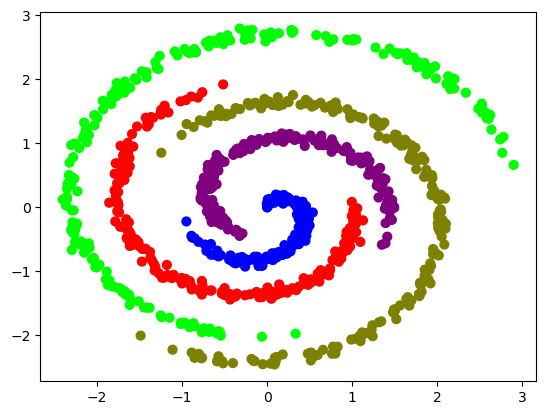

In [34]:
#
#Unbalanced Spiral Generate a 2D dataset consisting of 5 classes arranged in a spiral pattern. 
#The dataset has a total of 1000 points, with 200 points per class
N = 200 # number of points per class
D = 2 # dimensionality
K = 5 # number of classes
X = np . zeros (( N *K , D ) ) # data matrix ( each row = single example )
y = np . zeros ( N *K , dtype ='uint8') # class labels
for j in range ( K ) :
    ix = range (N *j , N *( j +1) )
    r = np . linspace (0.0 ,1 , N ) # radius
    r = r + j *0.5
    t = np.linspace(j *4 ,( j +1) *4 , N ) + np . random . randn ( N ) *0.2 # theta
    # print (t)
    X [ ix ] = np.c_[r*np.sin(t),r*np.cos(t)]
    y [ ix ] = j
spiral4 = np.column_stack((X,y))
plt.scatter(X[:,0],X[:,1],c=y,s=40,cmap ='brg')
plt.show()


In [35]:
A_train, A_test, b_train, b_test = train_test_split(X,y, test_size=0.3)
clf = DecisionTree(max_depth=5)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=0, threshold=-0.8937676674175363, information_gain=0.2153412752944166
Node: feature=0, threshold=-1.8143124815759633, information_gain=0.23466460852097482
Node: feature=0, threshold=-1.8739002804743001, information_gain=0.050965689545999115
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=0, threshold=-1.8578285460355313, information_gain=0.5004024235381879
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=-1.2568987114153753, information_gain=0.22250426576774684
Node: feature=1, threshold=-2.0023945212019076, information_gain=0.34883209584303193
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=1.676325234086977, information_gain=0.42522175195832046
Node: feature=0, threshold=-1.2494207928112058, information_gain=0.061550187987662194
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=2, class_probs=[0.        

In [36]:
accuracy_score(b_test,predictions)

0.9333333333333333

In [37]:
#Accuracy for random forest
clf = RandomForest(n_trees=10)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=0, threshold=-0.8555882970416234, information_gain=0.20115659147772513
Node: feature=0, threshold=-1.7819041336011163, information_gain=0.2760329842733905
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=-1.4670242076490572, information_gain=0.22825378970361743
Node: feature=1, threshold=-2.0023945212019076, information_gain=0.5455945739691843
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=1.676325234086977, information_gain=0.41830136392081935
Node: feature=1, threshold=-1.2568987114153753, information_gain=0.09186287644113442
Node: feature=1, threshold=-1.2810310597731691, information_gain=0.6730116670092565
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=0, threshold=-0.9557594071484555, information_gain=0.10579946702115953
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=1, threshold=-1.1505543545253292

In [38]:
accuracy_score(b_test,predictions)

0.9533333333333334

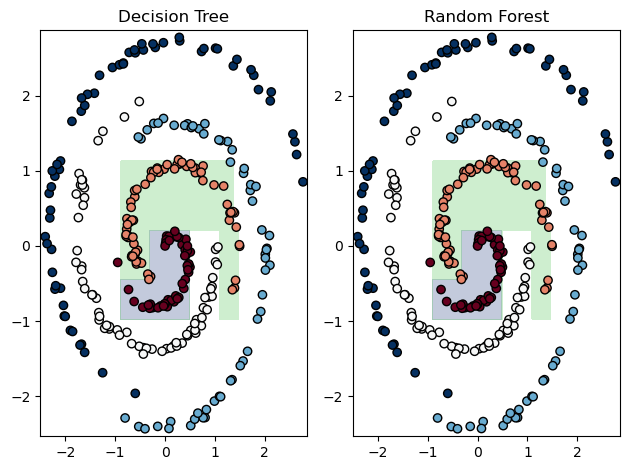

In [39]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, A_test, b_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, A_test, b_test)
plt.tight_layout()
plt.show()

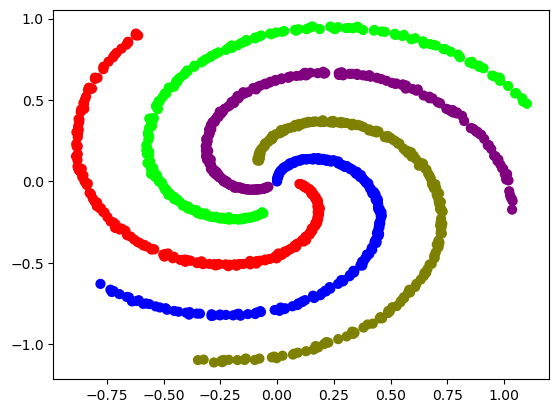

In [40]:
#Balanced Spiral This code generates a 2D dataset consisting of 5 classes arranged in a spiral pattern.
#The dataset has a total of 1000 points, with 200 points per class.
N = 200 # number of points per class
D = 2 # dimensionality
K = 5 # number of classes
X = np . zeros (( N *K , D ) ) # data matrix ( each row = single example )
y = np . zeros ( N *K , dtype ='uint8') # class labels
for j in range ( K ) :
    ix = range (N *j , N *( j +1) )
    r = np . linspace (0.0 ,1 , N ) # radius
    r = r + j *0.05
    # print (r)
    t = np . linspace ( j *4 ,( j +1) *4 , N ) + np . random . randn ( N ) *0.02 # theta
    # print (t)
    X [ ix ] = np . c_ [ r * np . sin ( t ) , r * np . cos ( t ) ]
    y [ ix ] = j
spiral5 = np . column_stack (( X , y ) )
plt . scatter ( X [: , 0] , X [: , 1] , c =y , s =40 , cmap ='brg')
plt . show ()

In [41]:
A_train, A_test, b_train, b_test = train_test_split(X,y, test_size=0.3)
clf = DecisionTree(max_depth=5)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=1, threshold=0.3787537260013493, information_gain=0.17479520468688592
Node: feature=0, threshold=-0.08200961669115876, information_gain=0.2297287353367239
Node: feature=1, threshold=-0.6283883472979099, information_gain=0.47842324946691417
Node: feature=1, threshold=-1.0860986152035517, information_gain=0.4570445330375596
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=0, class_probs=[1.]
Node: feature=0, threshold=-0.31438369686147655, information_gain=0.30272196620708525
Node: feature=0, threshold=-0.6048843561370343, information_gain=0.3306387160108884
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=4, class_probs=[0.         0.         0.26785714 0.         0.73214286]
Node: feature=1, threshold=-0.20795954851834603, information_gain=0.6571577614973405
Leaf node: value=4, class_probs=[0.         0.         0.39393939 0.         0.60606061]
Leaf node: value=1, class_probs=[0. 1.]
Node: feature=0, threshold=0.46166254876349777, information_gai

In [42]:
accuracy_score(b_test,predictions)

0.8366666666666667

In [43]:
clf = RandomForest(n_trees=10)
clf.fit(A_train, b_train)
predictions = clf.predict(A_test)

Node: feature=0, threshold=-0.3131104393944671, information_gain=0.17620846232568566
Node: feature=1, threshold=-0.6283883472979099, information_gain=0.4101163182884092
Leaf node: value=0, class_probs=[1.]
Node: feature=0, threshold=-0.6203279158186457, information_gain=0.42649750111580237
Leaf node: value=2, class_probs=[0. 0. 1.]
Node: feature=1, threshold=-0.41361373449806105, information_gain=0.44119154602876565
Leaf node: value=2, class_probs=[0. 0. 1.]
Leaf node: value=4, class_probs=[0. 0. 0. 0. 1.]
Node: feature=1, threshold=0.3757243524572834, information_gain=0.2600711776280409
Node: feature=0, threshold=-0.042819864237345136, information_gain=0.2110569213351725
Node: feature=1, threshold=-0.1978124289562199, information_gain=0.568095376617251
Node: feature=1, threshold=-0.8040724446329874, information_gain=0.6879319439065485
Node: feature=1, threshold=-1.0860986152035517, information_gain=0.6554817739013927
Leaf node: value=3, class_probs=[0. 0. 0. 1.]
Leaf node: value=0, cl

In [44]:
accuracy_score(b_test,predictions)

0.97

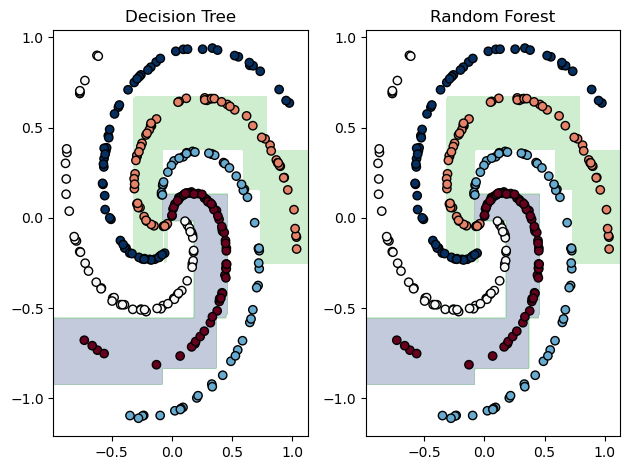

In [45]:
# Plot the decision boundary for the decision tree
plt.subplot(1, 2, 1)
plt.title('Decision Tree')
plot_decision_boundary(DecisionTree, A_test, b_test)
#Plot the decision boundary for the random forest
plt.subplot(1, 2, 2)
plt.title('Random Forest')
plot_decision_boundary(RandomForest, A_test, b_test)
plt.tight_layout()
plt.show()